# CNN - LSTM autoencoder model for waveform extraction from O2 noise


Evaluation of CNN-LSTM denoising autoencoder model on BBH samples injected in real noise alongwith test of robustness against Gaussian and sine-Gaussian glitch injections

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
import numpy as np
import pandas as pd
from SampleFileTools1 import SampleFile
import random as ran
import h5py


2023-04-04 05:27:49.320740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [163]:
f1 = h5py.File('/fred/oz016/denoising/q/100k_q_snr_10-30_4.hdf', 'r')
list(f1.keys())


['injection_parameters', 'signals', 'simulation_ranges']

In [164]:
f1['signals'].keys()


<KeysViewHDF5 ['H1 pure strain', 'H1 strain', 'H1 times', 'L1 pure strain', 'L1 strain', 'L1 times', 'V1 pure strain', 'V1 strain', 'V1 times']>

In [2]:
import h5py

strains_d = dict()
signals_d = dict()
f1 = h5py.File('/root/lzd2/Generated-Samples/test/sample2023-04-15-05-41-42.hdf', 'r')
# f1 = h5py.File('/root/lzd2/GravitationalWave/BBH_sample_files/default_snr.hdf', 'r')
list(f1.keys())
strains = []
signals = []
for det in ['h1','l1','v1']:
    strains_d[det] = f1['injection_samples']['{0}_strain'.format(det)][()]
    signals_d[det] = f1['injection_parameters']['{0}_signal'.format(det)][()]
strains.append(strains_d)
signals.append(signals_d)

strains = {
        'h1':np.concatenate([x['h1'] for x in strains]),
        'l1':np.concatenate([x['l1'] for x in strains]),
        'v1':np.concatenate([x['v1'] for x in strains])
    }

signals = {
        'h1':np.concatenate([x['h1'] for x in signals]),
        'l1':np.concatenate([x['l1'] for x in signals]),
        'v1':np.concatenate([x['v1'] for x in signals])
    }


In [3]:
f1.close()


# Normalize data

In [4]:
def normalize_test(a):
    new_array = []
    for i in range(100000):
        dataset = a[i]
#        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(512):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset+gauss
        new_array.append(dataset)
    return new_array

l1_test_new = normalize_test(strains['l1'])

#h1_pure_new = normalize_new(h1_pure_new)
l1_test_pure_new = normalize_test(signals['l1'])


# Reshape data into sub-sequences

In [5]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence_noisy,sequence_pure,n_steps):
    X, y = list(), list()
    for i in range(len(sequence_noisy)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence_noisy[i:end_ix], sequence_pure[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 4
X_test_noisy = []
X_test_pure = []

for i in range(100000):
    # TODO: 原来这里是h1_test_new
    X_noisy = l1_test_new[i]
    X_pure = l1_test_pure_new[i]
    X_noisy = np.pad(X_noisy, (4, 4), 'constant', constant_values=(0, 0))
    X_pure = np.pad(X_pure, (4, 4), 'constant', constant_values=(0, 0))
    # split into samples
    X, y = split_sequence(X_noisy, X_pure, n_steps)
    X_test_noisy.append(X)
    X_test_pure.append(y)
    
X_test_noisy = np.asarray(X_test_noisy)
X_test_pure = np.asarray(X_test_pure)


In [6]:
print('x_test_noisy shape: ', X_test_noisy.shape)
print('x_test_pure shape: ', X_test_pure.shape)

num_time_periods, num_detectors = 4, 1

input_shape = (num_time_periods*num_detectors)

X_test_noisy = X_test_noisy.reshape(X_test_noisy.shape[0], 516, input_shape)
X_test_pure = X_test_pure.reshape(X_test_pure.shape[0], 516, 1)

print('x_test_noisy shape:', X_test_noisy.shape)
print('input_shape:', input_shape)

print('x_test_pure shape:', X_test_pure.shape)
print('input_shape:', input_shape)

X_test_noisy = X_test_noisy.astype("float32")
X_test_pure = X_test_pure.astype("float32")


x_test_noisy shape:  (100000, 516, 4)
x_test_pure shape:  (100000, 516)
x_test_noisy shape: (100000, 516, 4)
input_shape: 4
x_test_pure shape: (100000, 516, 1)
input_shape: 4


# FracTAL Tanimoto loss function

In [7]:
#from keras import backend as K
def fractal_tanimoto_loss(y_true, y_pred, depth=0, smooth=1e-6):
    x = y_true
    y = y_pred
#    x_norm = K.sum(x)
#    y_norm = K.sum(y)
#    x = x/x_norm
#    y = y/y_norm
    depth = depth+1
    scale = 1./len(range(depth))
    
    def inner_prod(y, x):
        prod = y*x
        prod = tf.math.reduce_sum(prod, axis=1)
        
        return prod
    
    def tnmt_base(x, y):

        tpl  = inner_prod(y,x)
        tpp  = inner_prod(y,y)
        tll  = inner_prod(x,x)


        num = tpl + smooth
        denum = 0.0
        result = 0.0
        for d in range(depth):
            a = 2.**d
            b = -(2.*a-1.)

            denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
#            denum = ( a*(tpp+tll) + b *tpl + smooth)
#            result = tf.math.reduce_mean((result + (num/denum)), axis=0)

        result =  num * denum * scale
#        result = result
        return  result*scale
    
    
    l1 = tnmt_base(x,y)
#        l2 = self.tnmt_base(1.-preds, 1.-labels)

#        result = 0.5*(l1+l2)
    result = l1
    
    return  1. - result


# Load trained model

In [8]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/root/lzd2/GravitationalWave/BBH_sample_files/trained_model.h5', custom_objects={'fractal_tanimoto_loss': fractal_tanimoto_loss})
# summarize model.
model.summary()


2023-04-04 05:39:55.368930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 05:40:00.038130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13593 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 516, 4, 32)       64        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 516, 4, 32)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 516, 2, 32)       0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 516, 2, 16)       528       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 516, 2, 16)       0

# Obtain predictions on test data

In [9]:
decoded_signals = model.predict(X_test_noisy, batch_size=2000)

score = model.evaluate(X_test_noisy, X_test_pure, verbose=1, batch_size=2000)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


2023-04-04 05:40:22.091360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


50/50 [==============================] - 34s 223ms/step
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
50/50 [==============================] - 14s 229ms/step - loss: 0.1620 - accuracy: 0.0096

Accuracy on test data: 0.01

Loss on test data: 0.16


# Plot test sample

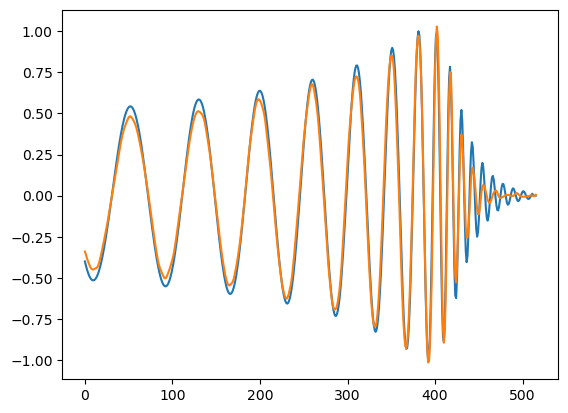

In [10]:
plt.plot(X_test_pure[0])
plt.plot(decoded_signals[0])
